In [1]:
from IPython.display import display, HTML

display(
    HTML("""
<style>
div.container{width:80% !important;}
div.prompt {min-width:70px;}
div#toc-header{margin-top:150px;}
span.toc-item-num{display:none;}
div.CodeMirror {font-family:Consolas}
div.input {font-family:Consolas}
</style>
"""))

# 1. LeNet : 최초의 CNN
```
<img src='image/LeNet.png' alt='LeNet' width=''>
```
![LeNet](image/LeNet.png)

FC(120) : 120개 출력층의 뉴런을 가진 Fully Connected 레이어

In [12]:
from tensorflow.keras import Sequential          # AveragePooling2D와 동일
from tensorflow.keras.layers import Input, Conv2D, AvgPool2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, Callback
import numpy as np
import pandas as pd  # crosstab
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [3]:
class CustomHistory(Callback):  # on_epoch_end()는 각 에포크 종료시 자동 호출
    def __init__(self, times=5):  # 생성자 함수
        self.epoch = 0
        self.times = times
    def on_epoch_end(self, batch, logs={}):
        self.epoch += 1
        if self.epoch%self.times == 0:
            print('epoch:{}, loss:{}, acc:{}, val_loss:{}, val_acc:{}'.format(self.epoch, logs.get('loss'), logs.get('accuracy'), logs.get('val_loss'), logs.get('val_accuracy')))

In [4]:
# 출력사이즈 = (입력사이즈 - 커널사이즈) / 스트라이드 + 1
class LeNet:
    @staticmethod
    def build(input_shape=(32, 32, 1), activation='relu'):
        model = Sequential()
        model.add(Input(shape=(input_shape)))
        model.add(Conv2D(6,  # 커널 갯수  # 32-5+1 = 28
                         kernel_size=(5, 5),
                         activation=activation,
                         kernel_initializer='he_normal',
                         padding='valid'))  # C1층  # 5*5*5+6
        model.add(AvgPool2D(pool_size=ading(2, 2),
                            strides=2,  # 스트라이드 사이즈는 기본이 pool_size (# strides=(2, 2))
                           ))  # P2층
        model.add(Conv2D(16, 
                         kernel_size=(5, 5),
                         activation=activation,
                         kernel_initializer='he_normal'))  # C3층
        model.add(AvgPool2D(pool_size=(2, 2), strides=2))  # P4층
        model.add(Flatten())  # 1차원으로
        model.add(Dense(units=120, activation='relu', kernel_initializer='he_normal'))  # F5층
        model.add(Dense(units=84,  activation='relu', kernel_initializer='he_normal'))  # F6층
        model.add(Dense(units=10,  activation='softmax'))  # 출력층
        return model

In [5]:
# 위와 같음
class LeNet:
    @staticmethod
    def build(input_shape=(32, 32, 1), activation='relu'):
        model = Sequential([
            Input(shape=(input_shape)),                                                             # 아래 input_shape=(28, 28, 1)로 적용 시
            Conv2D(6, kernel_size=(5, 5), activation=activation, kernel_initializer='he_normal'),   # 5*5*6+6 = 156
            AvgPool2D(pool_size=(2, 2), strides=2),
            Conv2D(16, kernel_size=(5, 5), activation=activation, kernel_initializer='he_normal'),  # 6*16*5*5*16 = 2416
            AvgPool2D(pool_size=(2, 2), strides=2),
            Flatten(),  # 1차원으로
            Dense(units=120, activation='relu', kernel_initializer='he_normal'),                    # 4*4*16*120+120 = 30840
            Dense(units=84,  activation='relu', kernel_initializer='he_normal'),                    # 120*84+84 = 10164
            Dense(units=10,  activation='softmax')  # 출력층                                         # 84*10+10 = 850
        ])
        return model

In [6]:
model = LeNet.build(input_shape=(28, 28, 1), activation='relu')
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 6)         156       
                                                                 
 average_pooling2d (AverageP  (None, 12, 12, 6)        0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 16)          2416      
                                                                 
 average_pooling2d_1 (Averag  (None, 4, 4, 16)         0         
 ePooling2D)                                                     
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 120)               3

In [9]:
# 1. 데이터
from tensorflow.keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
# 스케일 조정
X_train = X_train.reshape(-1, 28, 28, 1) / 255.0  # X_train.reshape(-1, 28, 28, 1).astype('float32')
X_test  = X_test.reshape(-1, 28, 28, 1) / 255.0
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)  # 원핫인코딩X

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)
(60000, 28, 28, 1) (60000,) (10000, 28, 28, 1) (10000,)


In [10]:
# 2. 모델생성
model = LeNet.build(input_shape=(28, 28, 1))  # activation='relu' 생략 가능
# 3. 학습설정
model.compile(loss='sparse_categorical_crossentropy',  # 원핫인코딩을 하지 않고 분류분석 시 내부적으로 원핫인코딩 처리
              optimizer='adam', metrics=['accuracy'])
# 4. 학습시키기
customHistory = CustomHistory(3)
earlystopping = EarlyStopping(patience=10)
hist = model.fit(X_train, y_train, validation_split=0.2, epochs=50, callbacks=[customHistory, earlystopping], verbose=0)

epoch:3, loss:0.05728743597865105, acc:0.9815833568572998, val_loss:0.06008723005652428, val_acc:0.981333315372467
epoch:6, loss:0.03120766021311283, acc:0.9898124933242798, val_loss:0.04504622519016266, val_acc:0.9879999756813049
epoch:9, loss:0.020192736759781837, acc:0.9933750033378601, val_loss:0.05250835791230202, val_acc:0.9854166507720947
epoch:12, loss:0.013868934474885464, acc:0.995312511920929, val_loss:0.04990001022815704, val_acc:0.9884166717529297
epoch:15, loss:0.010250719264149666, acc:0.9967708587646484, val_loss:0.04196725785732269, val_acc:0.9887499809265137


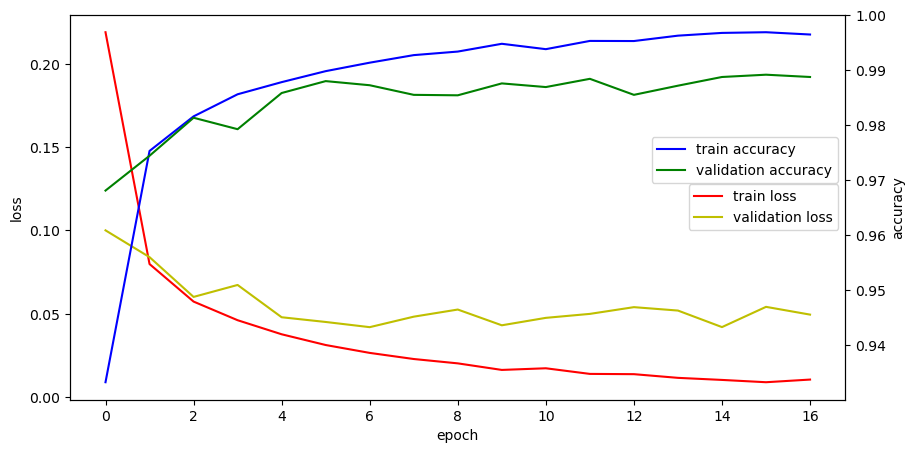

In [13]:
# 5. 학습과정 표시하기(validation(검증) dataset 없는 경우)
fig, loss_ax = plt.subplots(figsize=(10,5))
loss_ax.plot(hist.history['loss'], 'r', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'y', label='validation loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='validation accuracy')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='center right')
acc_ax.legend(bbox_to_anchor=(0.999, 0.7))
plt.show()

In [16]:
# 모델 평가하기
loss, accuracy = model.evaluate(X_test, y_test)
print('accuracy : {:.2f}'.format(accuracy*100))

313/313 [==============================] - 1s 4ms/step - loss: 0.0491 - accuracy: 0.9887
accuracy : 98.87


In [22]:
# 예측치와 실제값을 이용한 교차표
yhat = model.predict(X_test).argmax(axis=1)  # 예측치
# yhat = np.argmax(model.predict(X_test), axis=1)
display(pd.crosstab(y_test, yhat))  # 실제값, 예측치 : 결과 - 데이터프레임
# print(confusion_matrix(y_test, yhat))  # 결과 - 넘파이배열

cnt = 0
for y, h in zip(y_test, yhat):
    if y != h:
        cnt += 1
print('예측이 틀린 갯수 : ', cnt)

313/313 [==============================] - 1s 3ms/step


col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,974,0,1,0,1,0,2,1,1,0
1,0,1126,1,1,0,1,0,5,1,0
2,0,1,1020,1,0,0,0,7,3,0
3,0,0,2,995,0,6,0,4,2,1
4,0,0,0,0,973,0,4,1,0,4
5,1,0,0,5,0,879,1,0,6,0
6,2,3,0,1,1,1,946,0,4,0
7,0,2,4,0,0,0,0,1021,1,0
8,0,0,1,0,2,0,2,2,966,1


예측이 틀린 갯수 :  113


i =  2940
cnt =  50


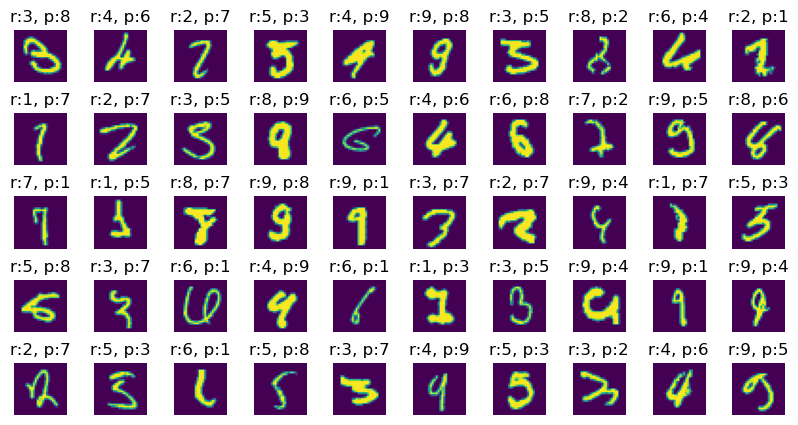

In [24]:
# 모델 학습 후 예측이 틀린 경우만 출력
plt_row = 5   # 5행 세로 
plt_col = 10  # 10열 가로
plt.rcParams['figure.figsize'] = (plt_col, plt_row)
# plt.rc('font', family='Malgun Gothic')  # 윈도우즈 os
fig, axarr = plt.subplots(nrows=plt_row, ncols=plt_col)
plt.subplots_adjust(hspace=0.6, wspace=0.4)  # 상하여백, 좌우여백

i = 0    # y_hat과 y_test를 액세스할 index
cnt = 0  # 출력할 횟수
while (cnt < plt_row*plt_col) & (i < len(y_test)):
    # 예측한 결과가 틀렸을 경우만 imshow(X_test[i]), 실제값과 예측치를 title에 출력
    if yhat[i] == y_test[i]:  # 실제값 == 예측치일 경우
        i += 1
        continue
    # 예측한 값과 실제값이 다른 경우
    sub_plot = axarr[cnt // plt_col, cnt % plt_col]
    sub_plot.imshow(X_test[i].reshape(28, 28))  # 예측이 틀린 그림
    title = 'r:{}, p:{}'.format(y_test[i], yhat[i])
    sub_plot.set_title(title)
    sub_plot.axis('off')
    i += 1
    cnt += 1
print('i = ', i)
print('cnt = ', cnt)

# 2. AlexNet
 - GPU를 사용하여 실현 가능한 모델. 알렉스와 제프리힌튼이 공동 설계한 CNN 아키텍처 이름.
 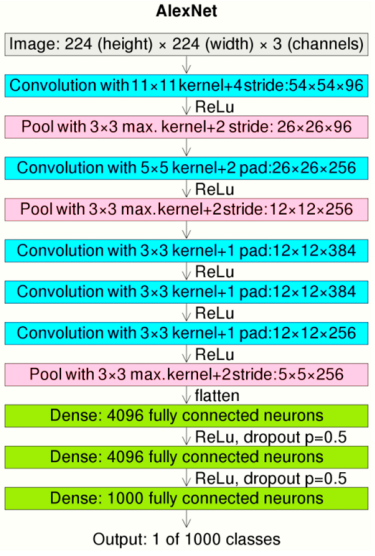

In [ ]:
# Google colab
from google.colab import drive
drive.mount('/content/drice')

In [ ]:
# GPU 확인
import tensorflow as tf
print(tf.__version__)
tlist_physical_devices.list_physical_devices('GPU')

In [27]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization  # 배치졍규화
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [6]:
# 출력사이즈 = (입력사이즈 - 커널사이즈) / 스트라이드 + 1
class AlexNet:
    @staticmethod
    def build(input_shape=(224, 224, 3), activation='relu', class_num=1000):
        model = Sequential([
            Input(shape=input_shape),
            Conv2D(96,  # 커널갯수
                   kernel_size=(11, 11),
                   strides=(4, 4),
                   activation=activation,
                   padding='same'),  # 두 번째 MaxPooling 오류 방지를 위함
            MaxPooling2D(pool_size=(3, 3), strides=2),
            BatchNormalization(),  # 배치졍규화
            Conv2D(256, kernel_size=(5, 5), activation=activation, padding='same'),
            MaxPooling2D(pool_size=(3, 3), strides=2),
            BatchNormalization(),
            Conv2D(384, kernel_size=(3, 3), activation=activation, padding='same'),
            Conv2D(384, kernel_size=(3, 3), activation=activation, padding='same'),
            Conv2D(256, kernel_size=(3, 3), activation=activation, padding='same'),
            # AlexNet은 224*224 이미지에 맞춰서 3*3 pooling이 되나,
            # cifar 32*32 이미지에서는 아래의 MaxPooling단계는 생략
            # MaxPooling2D(pool_size=(3, 3), strides=2),
            Flatten(),            
            Dense(units=4096, activation=activation),
            Dropout(0.5),
            Dense(units=4096, activation=activation),
            Dropout(0.5),
            Dense(units=class_num, activation='softmax')  # 출력층
        ])
        return model

In [7]:
model = AlexNet.build(input_shape=(32, 32, 3))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 8, 8, 96)          34944     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 3, 3, 96)         0         
 2D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 3, 3, 96)         384       
 hNormalization)                                                 
                                                                 
 conv2d_11 (Conv2D)          (None, 3, 3, 256)         614656    
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 1, 1, 256)        0         
 2D)                                                             
                                                      

In [8]:
# 1. 데이터 (원핫인코딩X)
from tensorflow.keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train.shape, y_train.shape, X_test.shape, y_test.shape

170498071/170498071 [==============================] - 28s 0us/step


((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

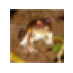

array([6], dtype=uint8)

In [15]:
# airplane(0), automobile(1), bird(2), cat(3), deer(4), dog(5), frog(6), horse(7), ship(8), truck(9) 中 하나
plt.figure(figsize=(0.7, 0.7))
plt.imshow(X_train[0])
plt.axis('off')
plt.show()
y_train[0]  # 이미지 위치 : array([6], dtype=uint8) : frog

In [17]:
# 스케일 조정
X_train = X_train / 255.0
X_test  = X_test / 255.0
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

In [19]:
# 2. 모델 생성
# model = AlexNet.build(input_shape=(32, 32, 3), class_num=10)  # 학습시간 단축을 위해 아래 모델을 사용함
model = Sequential([
            Input(shape=(32, 32, 3)),
            Conv2D(96,  # 커널갯수
                   kernel_size=(11, 11),
                   strides=(4, 4),
                   activation='relu',
                   padding='same'),  # 11*11*96*3(채널수)+96(출력수) = 34944
            MaxPooling2D(pool_size=(3, 3), strides=2),
            BatchNormalization(),  # 배치정규화
            
            Conv2D(384, kernel_size=(3, 3), activation='relu', padding='same'),  # 96*3*3*384+384 = 332160
            Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),  # 384*3*3*256+256 = 884992

            Flatten(),            
            Dense(units=1024, activation='relu'),  # 2360320
            Dropout(0.4),
            Dense(units=512, activation='relu'),   # 1024*512+512 = 524800
            Dropout(0.3),
            Dense(units=10, activation='softmax')  # 출력층
])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 8, 8, 96)          34944     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 3, 3, 96)         0         
 2D)                                                             
                                                                 
 batch_normalization_7 (Batc  (None, 3, 3, 96)         384       
 hNormalization)                                                 
                                                                 
 conv2d_19 (Conv2D)          (None, 3, 3, 384)         332160    
                                                                 
 conv2d_20 (Conv2D)          (None, 3, 3, 256)         884992    
                                                                 
 flatten_4 (Flatten)         (None, 2304)             

In [22]:
# 3. 학습설정
model.compile(loss='sparse_categorical_crossentropy',  # 원핫인코딩을 하지 않고 분류분석 시 내부적으로 원핫인코딩 처리
              optimizer='adam',
              metrics=['accuracy'])
# 4. 학습시키기
hist = model.fit(X_train, y_train, epochs=20, validation_data=[X_test, y_test])

Epoch 1/20
1563/1563 [==============================] - 164s 104ms/step - loss: 1.6369 - accuracy: 0.4104 - val_loss: 1.4731 - val_accuracy: 0.4668
Epoch 2/20
1563/1563 [==============================] - 177s 113ms/step - loss: 1.3632 - accuracy: 0.5182 - val_loss: 1.6192 - val_accuracy: 0.4292
Epoch 3/20
1563/1563 [==============================] - 175s 112ms/step - loss: 1.2309 - accuracy: 0.5712 - val_loss: 1.5648 - val_accuracy: 0.4621
Epoch 4/20
1563/1563 [==============================] - 158s 101ms/step - loss: 1.1272 - accuracy: 0.6087 - val_loss: 1.3745 - val_accuracy: 0.5310
Epoch 5/20
1563/1563 [==============================] - 156s 100ms/step - loss: 1.0471 - accuracy: 0.6393 - val_loss: 1.2118 - val_accuracy: 0.5878
Epoch 6/20
1563/1563 [==============================] - 157s 101ms/step - loss: 0.9723 - accuracy: 0.6607 - val_loss: 1.2087 - val_accuracy: 0.5919
Epoch 7/20
1563/1563 [==============================] - 150s 96ms/step - loss: 0.9038 - accuracy: 0.6877 - val_l

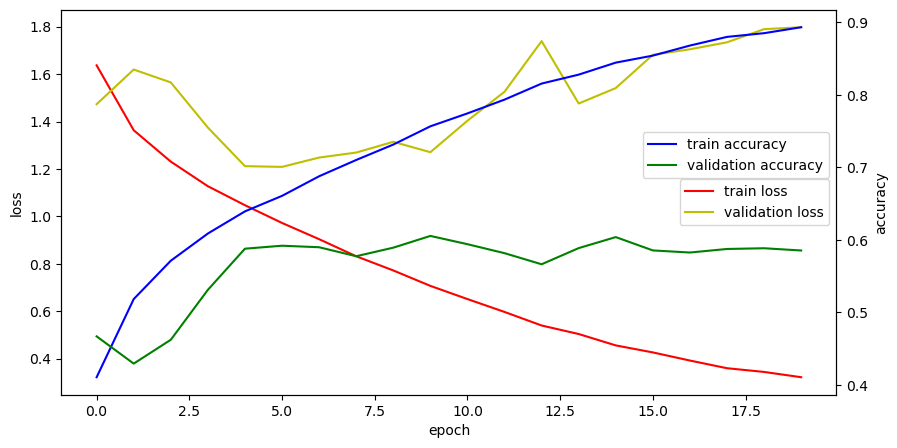

In [24]:
# 5. 학습과정 살펴보기, 모델 평가, 교차표
# 5. 학습과정 표시하기(validation(검증) dataset 없는 경우)
fig, loss_ax = plt.subplots(figsize=(10,5))
loss_ax.plot(hist.history['loss'], 'r', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'y', label='validation loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='validation accuracy')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='center right')
acc_ax.legend(bbox_to_anchor=(0.999, 0.7))
plt.show()

In [25]:
# 5. 모델 평가
loss, accuracy = model.evaluate(X_test, y_test)
print('loss : ', loss)
print('accuracy : ', accuracy)

313/313 [==============================] - 5s 16ms/step - loss: 1.7977 - accuracy: 0.5853
loss :  1.7976685762405396
accuracy :  0.5853000283241272


In [29]:
# 5. 교차표
# airplane(0), automobile(1), bird(2), cat(3), deer(4), dog(5), frog(6), horse(7), ship(8), truck(9) 中 하나
# y_test.reshape(-1)  # 실제값을 1차원으로 변경한 값
y_hat = np.argmax(model.predict(X_test), axis=1)  # 1차원
ctab = pd.crosstab(y_test.reshape(-1), y_hat)
ctab.columns = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
ctab.columns.name = 'predict'  # 예측값
ctab.index = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
ctab.index.name = 'real'  # 실제값

313/313 [==============================] - 5s 15ms/step


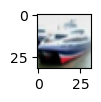

In [34]:
# 6. 모델 사용하기(예측하기)
plt.figure(figsize=(0.7, 0.7))
plt.imshow(X_test[1])
y_test[1]
plt.show()

In [35]:
pred = model.predict(X_test[1].reshape(-1, 32, 32, 3)).argmax(axis=1)
pred

1/1 [==============================] - 0s 31ms/step


array([8], dtype=int64)

# 3. VGGNet(Visual Geometry Group)
 - 옥스퍼드 대 VGG팀에서 구현한 CNN(컨볼루션과 맥스폴링 19개층)
 - VGG-19 구현

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications.vgg19 import VGG19
import cv2  # pip install opencv-python : 이미지 사이즈 조정
import matplotlib.pyplot as plt

In [2]:
class Vgg19:
    @staticmethod
    def build(input_shape=(224, 224, 3), activation='relu'):
        model = Sequential([
            Input(shape=(input_shape)),
            Conv2D(64, kernel_size=(3, 3), activation=activation, padding='same'),
            Conv2D(64, kernel_size=(3, 3), activation=activation, padding='same'),
            MaxPooling2D(),
            Conv2D(128, kernel_size=(3, 3), activation=activation, padding='same'),
            Conv2D(128, kernel_size=(3, 3), activation=activation, padding='same'),
            MaxPooling2D(),
            Conv2D(256, kernel_size=(3, 3), activation=activation, padding='same'),
            Conv2D(256, kernel_size=(3, 3), activation=activation, padding='same'),
            Conv2D(256, kernel_size=(3, 3), activation=activation, padding='same'),
            Conv2D(256, kernel_size=(3, 3), activation=activation, padding='same'),
            MaxPooling2D(),
            Conv2D(512, kernel_size=(3, 3), activation=activation, padding='same'),
            Conv2D(512, kernel_size=(3, 3), activation=activation, padding='same'),
            Conv2D(512, kernel_size=(3, 3), activation=activation, padding='same'),
            Conv2D(512, kernel_size=(3, 3), activation=activation, padding='same'),
            MaxPooling2D(),
            Conv2D(512, kernel_size=(3, 3), activation=activation, padding='same'),
            Conv2D(512, kernel_size=(3, 3), activation=activation, padding='same'),
            Conv2D(512, kernel_size=(3, 3), activation=activation, padding='same'),
            Conv2D(512, kernel_size=(3, 3), activation=activation, padding='same'),
            MaxPooling2D(),
            Flatten(),
            Dense(units=4096, activation='relu'),
            Dense(units=4096, activation='relu'),
            Dense(units=1000, activation='softmax')
        ])
        return model

In [3]:
model = Vgg19.build()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                    

In [5]:
vggModel = VGG19()  # 학습을 하지 않고 imageNet으로 학습이 끝난 model&weights를 내려받아 가중치만 사용
weights = vggModel.get_weights()
model.set_weights(weights=weights)  # 학습이 끝난 가중치를 model에 이식
# 추가적인 재학습도 가능함

In [10]:
# model.predict(읽어온 이미지를 224*224*3 넘파이 배열로 바꾼 값)
# 예측하기 위해 이미지를 읽어오기 -> 사이즈 조정(openCV 라이브러리 이용 : pip install opencv-python)

# 방법1
img_cv2 = cv2.imread('data/sample.jpg', 
                     cv2.IMREAD_COLOR,  # BGR포맷. 알파(투명도) 채널 무시
                     # cv2.IMREAD_UNCHANGED,  # 투명도까지 그대로 읽음
                     # cv2.IMREAD_GRAYSCALE     # 흑백으로 읽음
                    )
img_cv2 = cv2.resize(img_cv2, dsize=(224, 224),  # INTER_NEAREST 보간법을 이용하여 사이즈 조정
                     interpolation=cv2.INTER_NEAREST)

cv2.imshow('sample', img_cv2)
cv2.waitKey(0)           # 키보드 입력(마우스 클릭)을 기다림. 이미지가 화면에 표시된 상태를 유지
cv2.destroyAllWindows()  # openCV를 통해 생성된 몯느 창을 닫음
img_cv2.shape

(224, 224, 3)

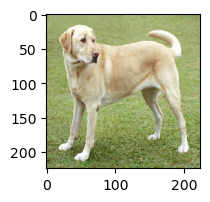

numpy.ndarray

In [16]:
plt.figure(figsize=(2, 2))
# BGR 포맷인 img_cv2를 RGV 포맷으로 바꾸기
img_cv2_rgb = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB) 
plt.imshow(img_cv2_rgb)
plt.show()
type(img_cv2_rgb)

In [21]:
# 방법2
from tensorflow.keras.preprocessing import image
img = image.load_img('data/sample.jpg', target_size=(224, 224))
print(type(img))
img_data = image.img_to_array(img)  # img를 넘파이배열로
print('읽어온 img_data의 type: ', type(img_data), ', img_data의 shape : ', img_data.shape)

<class 'PIL.Image.Image'>
읽어온 img_data의 type:  <class 'numpy.ndarray'> , img_data의 shape :  (224, 224, 3)


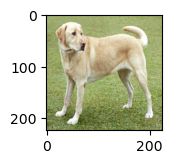

In [25]:
plt.figure(figsize=(1.5, 1.5))
plt.imshow(img)
plt.show()

(numpy.ndarray, (224, 224, 3))

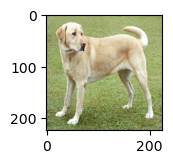

In [31]:
# 방법3
img_data1 = plt.imread('data/sample.jpg')
img_data1 = cv2.resize(img_data1, dsize=(224, 224), interpolation=cv2.INTER_NEAREST)  # 사이즈 조정

plt.figure(figsize=(1.5, 1.5))
plt.imshow(img_data1)
type(img_data1), img_data1.shape

In [33]:
img_data.shape, img_data1.shape

((224, 224, 3), (224, 224, 3))

In [41]:
# 차원 변경 (224, 224, 3) => (1, 224, 224, 3) 하는 방법들
import numpy as np
a = np.array([1, 2, 3])
print('a의 shape : ', a.shape)  # 1차원
# a의 shape (3, ) => (1, 3) : newaxis를 이용한 축 추가, reshape을 이용한 shape
print('a 배열에 축 추가(3행1열) : \n', a[:, np.newaxis])
print('a 배열에 축 추가(1햏3열) : \n', a[np.newaxis, :])
print('a 배열에 축 추가(1햏3열) : \n', a[np.newaxis, ...])
print('a 배열의 reshape : ', a.reshape(-1, 3))

a의 shape :  (3,)
a 배열에 축 추가(3행1열) : 
 [[1]
 [2]
 [3]]
a 배열에 축 추가(1햏3열) : 
 [[1 2 3]]
a 배열에 축 추가(1햏3열) : 
 [[1 2 3]]
a 배열의 reshape :  [[1 2 3]]


In [43]:
# 예측하기
pred = model.predict(img_data[np.newaxis, ...])
pred.argmax()

1/1 [==============================] - 0s 413ms/step


208

In [44]:
# 예측하기
pred = model.predict(img_data1[np.newaxis, ...])
pred.argmax()

1/1 [==============================] - 1s 628ms/step


208

In [56]:
from tensorflow.keras.applications.vgg19 import decode_predictions  # predict한 결과를 알려줌
result = decode_predictions(pred, top=5)[0]  # 1차원
result
for row in result:
    print('{}일 확률 : {}%'.format(row[1], round(row[2]*100, 2)))

Labrador_retriever일 확률 : 75.25%
Weimaraner일 확률 : 13.01%
kuvasz일 확률 : 2.97%
Great_Dane일 확률 : 2.02%
bloodhound일 확률 : 1.5%


# 4. 인셉션 모듈
 - 교안 p.55~
     * 1x1(커널) 컨볼루션을 하는 이유 : 채널 수를 줄여 연산속도를 높이기 위함

In [1]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import concatenate

In [2]:
model_input = Input(shape=(28, 28, 3))
# x = Flatten()(model_input)         # 내부적으로 Dense 앞 단에서 Flatten처리 됨
pre = Dense(units=192)(model_input)  # 맨 위의 3이 192개가 됨. 28*28*192 = 150720
conv1 = Conv2D(64,                   # 커널(필터) 갯수
               kernel_size=1,        # 커널 사이즈. kernel_size=(1, 1)과 같음
               padding='same')(pre)  # (pre) : 병렬처리
             # padding='same' : 28*28로 입출력 크기가 모두 같으므로
conv2 = Conv2D(128, kernel_size=3, padding='same')(pre)  
conv3 = Conv2D(32,  kernel_size=5, padding='same')(pre)
pool  = MaxPooling2D(pool_size=(3, 3), strides=1, padding='same')(pre)  # strides=1:사이즈동일(padding='same'), 2:사이즈1/2, 3:사이즈1/3
model_output = concatenate([conv1, conv2, conv3, pool])  # 리스트에 담음
model = Model(inputs=model_input, outputs=model_output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 3)]  0           []                               
                                                                                                  
 dense (Dense)                  (None, 28, 28, 192)  768         ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 64)   12352       ['dense[0][0]']                  
                                                                                                  
 conv2d_1 (Conv2D)              (None, 28, 28, 128)  221312      ['dense[0][0]']                  
                                                                                              

- GoogLeNet 중 Inception 모듈, Bottle Neck 구조
- GoogLeNet에서 소개된 핵심 요소로, 이미지 분류와 같은 작업에서 효율적이고 강력한 성능을 제공
```
![image](image/인셉션모듈.png)
```
<img src='image/인셉션모듈.png' alt='image' width='600'>

In [2]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, concatenate
model_input = Input(shape=(28, 28, 3))
pre = Dense(units=192)(model_input)

conv1 = Conv2D(64, kernel_size=1, padding='same')(pre)

conv2_1 = Conv2D(96,  kernel_size=1, padding='same')(pre)
conv2   = Conv2D(128, kernel_size=3, padding='same')(conv2_1)

conv3_1 = Conv2D(16, kernel_size=1, padding='same')(pre)
conv3   = Conv2D(32, kernel_size=5, padding='same')(conv3_1)

pool  = MaxPooling2D(pool_size=(3, 3), strides=1, padding='same')(pre)
conv4 = Conv2D(32, kernel_size=1, padding='same')(pool)

model_output = concatenate([conv1, conv2, conv3, conv4])
model = Model(inputs=model_input, outputs=model_output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 3)]  0           []                               
                                                                                                  
 dense (Dense)                  (None, 28, 28, 192)  768         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 28, 28, 96)   18528       ['dense[0][0]']                  
                                                                                                  
 conv2d_3 (Conv2D)              (None, 28, 28, 16)   3088        ['dense[0][0]']                  
                                                                                              

# 5. Residual block
```
![Residual Block](image/residual_block.png)
```
<img src='image/residual_block.png' alt='Residual Block' width='200' style='float:left'>

In [3]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, Activation, add
model_input = Input(shape=(28, 28, 3))

x = Conv2D(64, kernel_size=3, padding='same', activation='relu')(model_input)

# residual block
conv = Conv2D(32, kernel_size=3, padding='same', activation='relu')(x)
conv = Conv2D(64, kernel_size=3, padding='same', activation='relu')(conv)

y = add([conv, x])
y = Activation('relu')(y)

model_output = Conv2D(64, kernel_size=3, activation='relu')(y)

model = Model(inputs=model_input, outputs=model_output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 28, 28, 3)]  0           []                               
                                                                                                  
 conv2d_3 (Conv2D)              (None, 28, 28, 64)   1792        ['input_3[0][0]']                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 28, 28, 32)   18464       ['conv2d_3[0][0]']               
                                                                                                  
 conv2d_5 (Conv2D)              (None, 28, 28, 64)   18496       ['conv2d_4[0][0]']               
                                                                                              

# 6. 케라스 모델 가져오기

In [4]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import decode_predictions
import numpy as np

model = ResNet50()
# weights=None : 랜덤값으로 초기화된 상태의 가중치
# weights='imagenet'(기본값) : imagenet 데이터로 학습이 끝난 가중치 (224, 224, 3 이미지 -> 1000 분류)
# model.summary()

In [6]:
json_str = model.to_json()
# json_str
with open('model/model.json', 'w') as json_file:
    json_file.write(json_str)

In [8]:
from tensorflow.keras.models import model_from_json
with open('model/model.json', 'r') as f:
    json_str2 = f.read()
model2 = model_from_json(json_str2)  # json으로 가져올 경우 구조만 가져옴. 학습을 새로 해야 함.
# model2.summary()

In [23]:
# 이미지를 예측하기 위해 이미지 파일을 넘파이 배열로 가져오는 방법 4가지

# 방법1
import cv2
img_cv = cv2.imread('data/sample.jpg', cv2.IMREAD_COLOR)  # 넘파이 배열(BGR포맷)로 가져옴
# type(img_cv), img_cv.shape
img_cv2 = cv2.resize(img_cv, dsize=(224, 224), interpolation=cv2.INTER_NEAREST)
img_data = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB)
print('방법1(전부 넘파이) : ', img_data.shape, img_cv2.shape, img_cv.shape)

# 방법2
from tensorflow.keras.preprocessing import image  # 객체 가져오기
img = image.load_img('data/sample.jpg', target_size=(224, 224))  # image클래스 타입으로 가져옴(타겟사이즈 지정 가능)
# type(img)
img_data = image.img_to_array(img)  # 넘파이 배열로 형변환
print('방법2(image타입으로 읽어 넘파이로 형변환) : ', img_data.shape, type(img), type(img_data))

# 방법3
from matplotlib import pyplot as plt
import cv2
img_plt = plt.imread('data/sample.jpg')  # 넘파이 배열
# type(img_plt)
img_data = cv2.resize(img_plt, dsize=(224, 224), interpolation=cv2.INTER_NEAREST)
print('방법3(전부 넘파이) : ', img_data.shape, img_plt.shape)

# 방법4
from PIL import Image  # pip install pil(pillow)
import numpy as np
import cv2
imageFile = Image.open('data/sample.jpg')
# type(imageFile)  # 파일형식에 따른 타입
img_numpy = np.array(imageFile)  # 넘파이 배열로 형변환
# type(img_numpy)  # 넘파이 배열
img_data = cv2.resize(img_numpy, dsize=(224, 224), interpolation=cv2.INTER_NEAREST)
print('방법4 : ', img_data.shape)

방법1(전부 넘파이) :  (224, 224, 3) (224, 224, 3) (577, 700, 3)
방법2(image타입으로 읽어 넘파이로 형변환) :  (224, 224, 3) <class 'PIL.Image.Image'> <class 'numpy.ndarray'>
방법3(전부 넘파이) :  (224, 224, 3) (577, 700, 3)
방법4 :  (224, 224, 3)


In [31]:
# 모델 사용하기
# 모델 예측 시 매개변수로 들어갈 데이터의 축 추가
# 방법1
x = np.expand_dims(img_data, axis=0)
print('방법1 : ', x.shape)
# 방법2
x = img_data[np.newaxis, :]  # : or ...
print('방법2 : ', x.shape)
# 방법3
x = img_data[np.newaxis, ...]  # : or ...
print('방법3 : ', x.shape)
# 방법4
x = img_data.reshape(-1, 224, 224, 3)
print('방법4 : ', x.shape)

방법1 :  (1, 224, 224, 3)
방법2 :  (1, 224, 224, 3)
방법3 :  (1, 224, 224, 3)
방법4 :  (1, 224, 224, 3)


In [35]:
pred = model.predict(x)
pred.argmax()  # argmax() : 숫자가 가장 큰 값의 인덱스

1/1 [==============================] - 0s 157ms/step


208

In [36]:
decode_predictions(pred, top=3)

[[('n02099712', 'Labrador_retriever', 0.115230106),
  ('n02108089', 'boxer', 0.1123909),
  ('n02099849', 'Chesapeake_Bay_retriever', 0.106657766)]]

# 7. 전이학습

In [2]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
resnet_model = ResNet50(input_shape=(200, 200, 3),
                        include_top=False)  # 모델의 최상위 계층(첫 번쨰 Dense층)은 포함하지 않고 가져옴. 전이학습 시 사용됨.
resnet_model.trainablebl = True  # 가중치의 업데이트 허용
# resnet_model.trainablebl = False  # 기존의 ResNet50의 가중치는 고정. 새로 추가된 가중치만 업데이트 허용.

model = Sequential()
model.add(resnet_model)
model.add(Flatten())
model.add(Dense(units=1024, activation='relu'))
model.add(Dense(units=3,    activation='softmax'))
model.summary()

94765736/94765736 [==============================] - 4s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 1024)              102761472 
                                                                 
 dense_1 (Dense)             (None, 3)                 3075      
                                                                 
Total params: 126,352,259
Trainable params: 126,299,139
Non-trainable params: 53,120
_________________________________________________________________
